As a note. If any of the errors abbout Y_true and Y_pred is thrown, just reshuffle the data or rerun it. This is just a know error with pythons metrics

https://github.com/scikit-learn/scikit-learn/issues/4033

In [0]:
#@title imports
import fnmatch
import math

from IPython import display
from matplotlib import cm
from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn import metrics
import tensorflow as tf
from tensorflow.python.data import Dataset
import tempfile
import io


# This line increases the amount of logging when there is an error.  You can
# remove it if you want less logging
tf.logging.set_verbosity(tf.logging.ERROR)

# Set the output display to have two digits for decimal places, for display
# readability only and limit it to printing 15 rows.
pd.options.display.float_format = '{:.2f}'.format
pd.options.display.max_rows = 15

In [0]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving googleplaystore.csv to googleplaystore (3).csv
User uploaded file "googleplaystore.csv" with length 1360155 bytes


In [0]:
COLUMNS = ["app", "category", "rating", "reviews", "size", "installs", "type", 
           "price", "content", "genres", "last_update", "current_version", "android_version"]
census_df = pd.read_csv(io.StringIO(uploaded['googleplaystore.csv'].decode('utf-8')), names=COLUMNS, skipinitialspace=True)
census_df = census_df.iloc[1:]
census_df.head(1)

,app,category,rating,reviews,size,installs,type,price,content,genres,last_update,current_version,android_version
1,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,19M,"10,000+",Free,0,Everyone,Art & Design,"January 7, 2018",1.0.0,4.0.3 and up


In [0]:

census_df['rating'] = pd.to_numeric(census_df['rating'], errors='coerce')
census_df['reviews'] = pd.to_numeric(census_df['reviews'], errors='coerce')
mean = census_df['rating'].mean()
census_df['rating'].fillna(mean, inplace=True)
mean = census_df['reviews'].mean()
census_df['reviews'].fillna(mean, inplace=True)
census_df = census_df.replace(np.nan, '', regex=True)

In [0]:
##this drops a bad row of the data that causes issues
# census_df = census_df.drop([10473, 10473], axis=0)

census_df = census_df.drop([10473, 10473], axis=0)
census_df = census_df.drop([9149, 9149], axis=0)
census_df.iloc[10473]

app                Wi-Fi Visualizer
category                      TOOLS
rating                         3.90
reviews                      132.00
size                           2.6M
installs                    50,000+
type                           Free
price                             0
content                    Everyone
genres                        Tools
last_update            May 17, 2017
current_version               0.0.9
android_version          2.3 and up
Name: 10476, dtype: object

In [0]:
#@title linear_scale, log_scale, and clip
# Linearly rescales to the range [0, 1]
def linear_scale(series):
  min_val = series.min()
  max_val = series.max()
  scale = 1.0 * (max_val - min_val)
  return series.apply(lambda x:((x - min_val) / scale))

# Perform log scaling
def log_scale(series):
  return series.apply(lambda x:math.log(x+1.0))

# Clip all features to given min and max
def clip(series, clip_to_min, clip_to_max):
  # You need to modify this to actually do the clipping versus just returning
  # the series unchanged.
  series = series.clip(clip_to_min, clip_to_max)
  return series.apply(lambda x: x)

In [0]:
def prepare_type_help(x):
  if(x == "Free"):
    return 0
  elif(x == "Paid"):
    return 1
  else:
    return 0

def prepare_type(series):
  return series.apply(lambda x: prepare_type_help(x))

In [0]:
def prepare_price_help(price):
  temp = price.replace('$', '')
  if(price == 'Everyone'):
    return 0
  else:
    return int(float(temp))
def prepare_price(series):
  return series.apply(lambda x: prepare_price_help(x))

In [0]:
#@title prepare_size
def prepare_size_help(size):
  size = size.replace(',', '')
  end = size[-1]
  if(end == "M"):
    return int(float(size[:-1]) * 1000000)
  elif(end == "k"):
    return int(float(size[:-1]) * 1000)
  elif(end == "+"):
    return int(float(size[:-1]))
  else:
    return 0
  
def replace_with_mean(x, mean):
  if(x == 0):
    return mean
  else:
    return x
  
def prepare_size(series):
  cop = series.apply(lambda x: prepare_size_help(x))
  mean = cop.mean()
  return cop.apply(lambda x: replace_with_mean(x, mean))
  

In [0]:

NUMERICAL_FEATURES = ["rating", "reviews", "size", "type", "price"]
CATEGORICAL_FEATURES = ["app", "category", "content", "genres", "last_update", "currmaent_version", "android_version"]

def prepare_features(dataframe):
  """Prepares the features for provided dataset.

  Args:
    dataframe: A Pandas DataFrame expected to contain the data.
  Returns:
    A new DataFrame that contains the features to be used for the model.
   
  """
  
  processed_features = dataframe.copy()

  possible_values = list(np.array(['0+', '1+', '5+', '10+', '50+', '100+', '500+', '1,000+', 
                                   '5,000+',  '10,000+', '50,000+', '100,000+', '500,000+', '1,000,000+', 
                                   '5,000,000+', '10,000,000+', '50,000,000+', '100,000,000+', 
                                   '500,000,000+', '1,000,000,000+']))
  
  processed_features["rating"] = linear_scale(log_scale(processed_features["rating"]))
  processed_features["reviews"] = linear_scale(log_scale(processed_features["reviews"]))
  processed_features["size"] = linear_scale(log_scale(prepare_size(processed_features["size"])))
  processed_features["price"] = log_scale(log_scale(prepare_price(processed_features["price"])))
  processed_features["type"] = prepare_type(processed_features["type"])

  
  return processed_features

In [0]:
#@title draw_histograms
copy = prepare_features(census_df)

clip_min = -np.inf
clip_max = np.inf

def draw_histograms(dataframe, feature_name,
                    clip_min = -np.inf, clip_max = np.inf):
  plt.figure(figsize=(20, 4))
  plt.subplot(1, 3, 1)
  plt.title(feature_name)
  histogram = dataframe[feature_name].hist(bins=50)

  plt.subplot(1, 3, 2)
  plt.title("linear_scaling")
  scaled_features = pd.DataFrame()
  scaled_features[feature_name] = linear_scale(
      clip(dataframe[feature_name], clip_min, clip_max))
  histogram = scaled_features[feature_name].hist(bins=50)
  
  plt.subplot(1, 3, 3)
  plt.title("log scaling")
  log_normalized_features = pd.DataFrame()
  log_normalized_features[feature_name] = log_scale(dataframe[feature_name])
  histogram = log_normalized_features[feature_name].hist(bins=50)

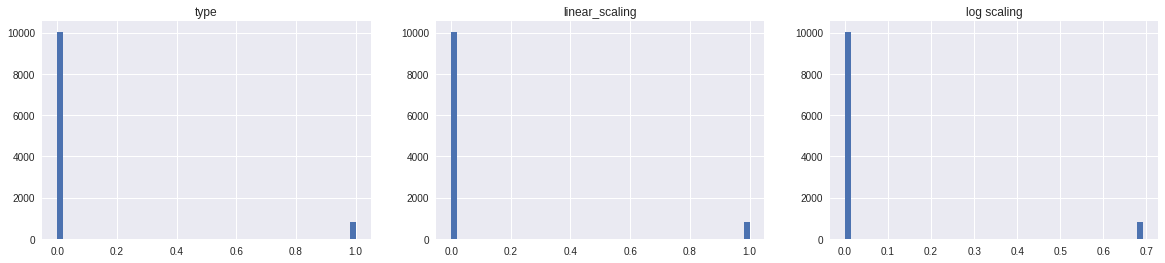

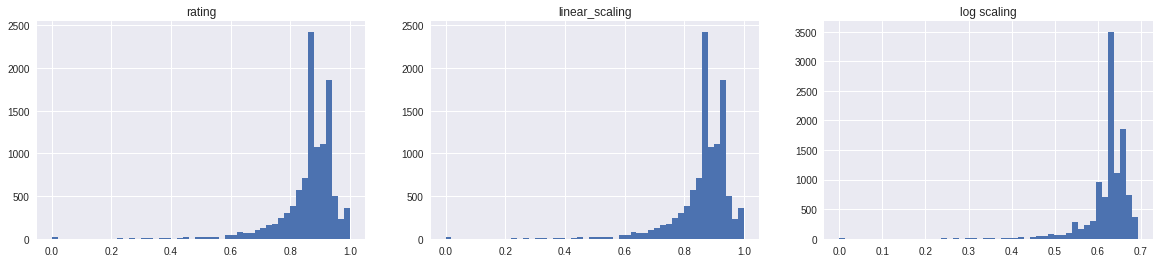

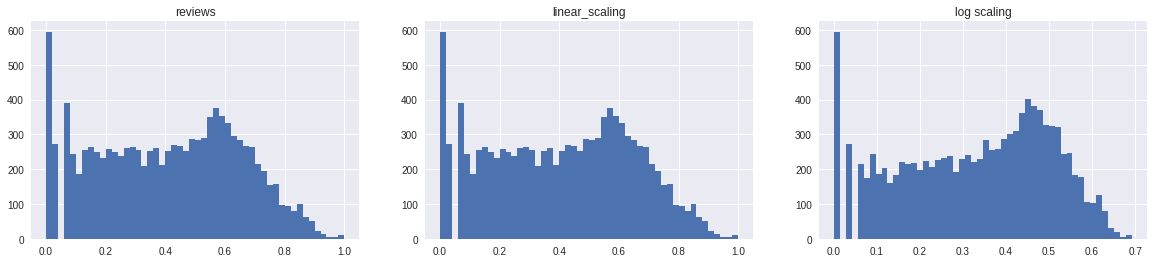

In [0]:
draw_histograms(copy, 'type')
draw_histograms(copy, 'rating')
draw_histograms(copy, 'reviews')

In [0]:
census_df = census_df.reindex(np.random.permutation(census_df.index))
training_examples = prepare_features(census_df.head(8000))
validation_examples = prepare_features(census_df.tail(1659))

In [0]:
def get_quantile_based_boundaries(feature_values, num_buckets):
  boundaries = np.arange(1.0, num_buckets) / num_buckets
  quantiles = feature_values.quantile(boundaries)
  return [q for q in quantiles]

In [0]:
#@title Basic stuff for the function to work
def input_fn(features, targets, batch_size=1, shuffle=True, num_epochs=None):
    """Defines a function to preprocess the data, as well as how to batch,
      shuffle, and repeat it during model training.
  
    Args:
      features: pandas DataFrame of features
      targets: pandas DataFrame of targets
      batch_size: Size of batches to be passed to the model
      shuffle: True or False. Whether to shuffle the data.
      num_epochs: Number of epochs for which data should be repeated. None = repeat indefinitely
    Returns:
      Tuple of (features, labels) for next data batch
    """
    
    # Convert pandas data into a dict of np arrays.
    features = {key:np.array(value) for key,value in dict(features).items()}                                           
 
    # Construct a dataset, and configure batching/repeating.
    ds = Dataset.from_tensor_slices((features,targets)) # warning: 2GB limit
    ds = ds.batch(batch_size).repeat(num_epochs)
    
    # Shuffle the data, if specified.
    if shuffle:
      ds = ds.shuffle(10000)
    
    # Return the next batch of data.
    features, labels = ds.make_one_shot_iterator().get_next()
    return features, labels

In [0]:
NUMERICAL_FEATURES = ["rating", "reviews", "size", "price", "type"]
CATEGORICAL_FEATURES = ["app", "category", "content", "genres", "last_update", "current_version", "android_version"]
FEATURES = NUMERICAL_FEATURES+ CATEGORICAL_FEATURES
LABEL = "installs"

# Here we define an input functon that uses the training examples generating
# batches of 10 examples
training_input_fn = lambda: input_fn(
    training_examples[NUMERICAL_FEATURES+CATEGORICAL_FEATURES], training_examples[LABEL], 
    batch_size=10)

# Here we define an input function that will compute the loss over the entire
# training set.
predict_training_input_fn = lambda: input_fn(
    training_examples[NUMERICAL_FEATURES+CATEGORICAL_FEATURES], training_examples[LABEL], 
    num_epochs=1, shuffle=False)

# Here we define an input function that will compute the loss over the entire
# validation set.
predict_validation_input_fn = lambda: input_fn(
    validation_examples[NUMERICAL_FEATURES+CATEGORICAL_FEATURES], validation_examples[LABEL], 
    num_epochs=1, shuffle=False)

In [0]:

  
def plot_learning_curve(training_losses, validation_losses):
  """ Plot the learning curve.
  
  Args:
    training_loses: a list of losses to plot.
    validation_losses: a list of validation losses to plot.
  """        
  plt.ylabel('Loss')
  plt.xlabel('Training Steps')
  plt.plot(training_losses, label="training")
  plt.plot(validation_losses, label="validation")
  plt.legend(loc=1)
  
def compute_loss(probabilities, targets):
  """ Computes the log loss for training a linear classifier.
  
  Args:
    probabilities: the model predictions as probabilities
    targets: a list of the target values being predicted that must be the
             same length as probabilities.
    
  Returns:
    The log loss for the provided probabilities and targets.
  """      
  return metrics.log_loss(targets, probabilities)

In [0]:
def train_model(model, training_features, training_labels,
                validation_features, validation_labels, steps, batch_size):
  """Trains a classifier.
  
  Args:
    model: The model to train
    training_features: The input features from the training data
    training_labels: the labels from the training data
    validation_features: The input features from the validation data
    validation_labels: the labels from the validation data
    steps: A non-zero `int`, the total number of training steps.
    batch_size: A non-zero `int`, the batch size.
    
  Returns:
    The trained model
  """
  # In order to see how the model evolves as we train it, we will divide the
  # steps into periods and show the model after each period.
  periods = 10
  steps_per_period = steps / periods
  
  # Set up the training_input_fn, predict_training_input_fn, and
  # predict_validation_input_fn
  training_input_fn = lambda: input_fn(training_features, training_labels,
                                       batch_size=batch_size)
  predict_training_input_fn = lambda: input_fn(training_features,
                                               training_labels,
                                               num_epochs=1, shuffle=False)
  predict_validation_input_fn = lambda: input_fn(validation_features,
                                                 validation_labels,
                                                 num_epochs=1, shuffle=False)
  
  # Train the model, but do so inside a loop so that we can periodically assess
  # loss metrics.  We store the training losses to generate the training curve
  print "Training model..."
  training_losses = []
  validation_losses = []

  for period in range (0, periods):
    # Train the classifier for steps_per_period steps
    _ = model.train(input_fn=training_input_fn, steps=steps_per_period)      
    
    # Use the predict method to compute the predictions as probabilities and
    # from that the training loss.
    probabilities = DNN_classifier.predict(input_fn=predict_training_input_fn)
    probabilities = np.array([item['probabilities'] for item in probabilities])
    training_loss = compute_loss(probabilities, training_labels)
    training_losses.append(training_loss) 
    
    # Also compute the validation loss   
    probabilities = DNN_classifier.predict(input_fn=predict_validation_input_fn)
    probabilities = np.array([item['probabilities'] for item in probabilities])
    validation_loss = compute_loss(probabilities, validation_labels)
    validation_losses.append(validation_loss) 
    print "  Training loss, Validation loss after period %02d : %0.3f, %0.3f" % \
      (period, training_loss, validation_loss)
      
  # Now that training is done print the final training and validation loss    
  print("Final Loss (Log Loss) on the training data: %0.3f" % training_loss) 
  print("Final Loss (Log Loss) on the validation data: %0.3f" % validation_loss) 
  
  # Generate a figure with the learning curve on the left and an ROC curve on
  # the right.
  plt.figure(figsize=(10, 5))
  plt.subplot(1, 2, 1)
  plt.title("Learning Curve (Loss vs time)")
  plot_learning_curve(training_losses, validation_losses)
  
  plt.subplot(1, 2, 2)
  plt.tight_layout(pad=1.1, w_pad=3.0, h_pad=3.0) 
  plt.title("ROC Curve on Validation Data")
  probabilities = DNN_classifier.predict(input_fn=predict_validation_input_fn)
  probabilities = np.array([item['probabilities'] for item in probabilities])

  # ROC curve uses the probability that the label is 1.
#   make_roc_curve(probabilities[:, 1], validation_examples[LABEL])
   
  return model

In [0]:
def plot_multiple_roc_curves(model_predictions, targets, model_names=[]):
  """ Creates a plot with a provided set of ROC curves
  Args:
    model_predictions: a list of lists, where sublist i is a list of
             predictions for model i.  For each sublist of model predictions,
             the jth element is the probability that example j is positive.
    targets: a list of the target values being predicted that must be the same
             length as each sublist in model_predictions.  Observe that the
             targets are the same for all models.
    model_names: a list the same length as model_predictions (or empty) where
             the ith element is the name to use for model i in the plot legend.
             
  """
  
  plt.ylabel("true positive rate")
  plt.xlabel("false positive rate")
  
  for i in range (0, len(model_predictions)):
      false_positive_rate, true_positive_rate, thresholds = metrics.roc_curve(
          targets, model_predictions[i])
      label = ""
      if len(model_names) > i:
        label = model_names[i]
      plt.plot(false_positive_rate, true_positive_rate, label=label)
  if len(model_names) > 0:
    plt.legend(loc=4)

In [0]:
def make_roc_curve(model_predictions, targets):
  """ Creates an ROC curve

  Args:
    model_predictions: the probability that the example has label 1
    targets: a list of the target values being predicted that must be the
             same size as predictions.
  """

  plot_multiple_roc_curves([model_predictions], targets)

In [0]:
def construct_feature_columns():
  """Construct TensorFlow Feature Columns for features
  
  Returns:
    A set of feature columns.
  """ 
  rating = tf.contrib.layers.real_valued_column("rating")
  reviews = tf.contrib.layers.real_valued_column("reviews")
  size = tf.contrib.layers.real_valued_column("size")
  price = tf.contrib.layers.real_valued_column("price")
  type_d = tf.contrib.layers.real_valued_column("type")
  
  category = tf.contrib.layers.sparse_column_with_hash_bucket( "category", hash_bucket_size=50)
  content = tf.contrib.layers.sparse_column_with_hash_bucket( "content", hash_bucket_size=50)
#   genres = tf.contrib.layers.sparse_column_with_hash_bucket( "genres", hash_bucket_size=50)
#   last_update = tf.contrib.layers.sparse_column_with_hash_bucket( "last_update", hash_bucket_size=50)
#   current_version = tf.contrib.layers.sparse_column_with_hash_bucket( "current_version", hash_bucket_size=50)
  android_version = tf.contrib.layers.sparse_column_with_hash_bucket( "android_version", hash_bucket_size=50)
  
  category = tf.contrib.layers.embedding_column(category, dimension=2)
  content = tf.contrib.layers.embedding_column(content, dimension=2)
  android_version = tf.contrib.layers.embedding_column(android_version, dimension=2)
    
  feature_columns=[rating, reviews, size, price, type_d, category, content, android_version]

  return feature_columns

In [0]:
def define_DNN_classifier(learning_rate,
                          hidden_units,
                          l1_regularization_strength=0.0,
                          l2_regularization_strength=0.0,
                          dropout_regularization=0.0):
  """ Defines a DNN classifer.
  
  Args:
    learning_rate: A `float`, the learning rate
    hidden_units: A `list` providing the hidden unit sizes
    l1_regularization_strength: A `float`, l1 regularization strength
    l2_regularization_strength: A `float`, l2 regularization strength
    
  Returns:
    A DNN created with the given parameters
  """
  
  # Use the Follow the Regularized Leader Optimizer
  optimizer=tf.train.FtrlOptimizer(
      learning_rate=learning_rate,
      l1_regularization_strength=l1_regularization_strength,
      l2_regularization_strength=l2_regularization_strength)
  
  optimizer = tf.contrib.estimator.clip_gradients_by_norm(optimizer, 5.0)
  DNN_classifier = tf.estimator.DNNClassifier(
    feature_columns=construct_feature_columns(),
    hidden_units=hidden_units,
    n_classes=20,
    label_vocabulary=list(np.unique(copy['installs'])),
    dropout = dropout_regularization,
    optimizer=optimizer
  )  
  return DNN_classifier

Training model...
  Training loss, Validation loss after period 00 : 1.259, 1.302
  Training loss, Validation loss after period 01 : 1.185, 1.219
  Training loss, Validation loss after period 02 : 1.170, 1.228
  Training loss, Validation loss after period 03 : 1.163, 1.202
  Training loss, Validation loss after period 04 : 1.157, 1.214
  Training loss, Validation loss after period 05 : 1.149, 1.202
  Training loss, Validation loss after period 06 : 1.147, 1.209
  Training loss, Validation loss after period 07 : 1.144, 1.188
  Training loss, Validation loss after period 08 : 1.141, 1.204
  Training loss, Validation loss after period 09 : 1.142, 1.192
Final Loss (Log Loss) on the training data: 1.142
Final Loss (Log Loss) on the validation data: 1.192


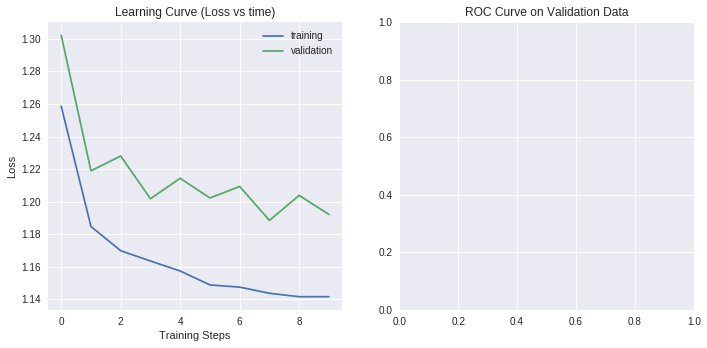

In [0]:
LEARNING_RATE = 0.15
L1_REGULARIZATION_STRENGTH = 0.0
L2_REGULARIZATION_STRENGTH = 0.1
DROPOUT_STRENGTH = 0.0
HIDDEN_UNITS = [14, 12, 8] #[7, 12, 13, 3]
BATCH_SIZE = 50
STEPS = 50000

DNN_classifier = define_DNN_classifier(
    learning_rate = LEARNING_RATE,
    hidden_units = HIDDEN_UNITS,
    l1_regularization_strength = L1_REGULARIZATION_STRENGTH,
    l2_regularization_strength = L2_REGULARIZATION_STRENGTH,
    dropout_regularization = DROPOUT_STRENGTH
)

DNN_classifier = train_model(
    DNN_classifier, training_examples[FEATURES],
    training_examples[LABEL], validation_examples[FEATURES],
    validation_examples[LABEL], batch_size=BATCH_SIZE, steps=STEPS)

Feel free to ignore the results below, Those are just so you can see previous results and tries
































_

Training model...
  Training loss, Validation loss after period 00 : 1.571, 1.565
  Training loss, Validation loss after period 01 : 1.492, 1.480
  Training loss, Validation loss after period 02 : 1.452, 1.460
  Training loss, Validation loss after period 03 : 1.417, 1.431
  Training loss, Validation loss after period 04 : 1.383, 1.385
  Training loss, Validation loss after period 05 : 1.380, 1.381
  Training loss, Validation loss after period 06 : 1.350, 1.356
  Training loss, Validation loss after period 07 : 1.349, 1.371
  Training loss, Validation loss after period 08 : 1.332, 1.343
  Training loss, Validation loss after period 09 : 1.321, 1.332
Final Loss (Log Loss) on the training data: 1.321
Final Loss (Log Loss) on the validation data: 1.332


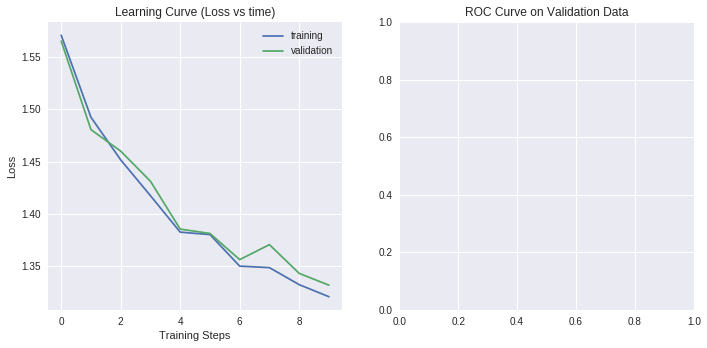

In [0]:
LEARNING_RATE = 0.15
L1_REGULARIZATION_STRENGTH = 0.0
L2_REGULARIZATION_STRENGTH = 0.1
DROPOUT_STRENGTH = 0.0
HIDDEN_UNITS = [25, 14, 8] #[7, 12, 13, 3]
BATCH_SIZE = 50
STEPS = 50000

DNN_classifier = define_DNN_classifier(
    learning_rate = LEARNING_RATE,
    hidden_units = HIDDEN_UNITS,
    l1_regularization_strength = L1_REGULARIZATION_STRENGTH,
    l2_regularization_strength = L2_REGULARIZATION_STRENGTH,
    dropout_regularization = DROPOUT_STRENGTH
)

DNN_classifier = train_model(
    DNN_classifier, training_examples[FEATURES],
    training_examples[LABEL], validation_examples[FEATURES],
    validation_examples[LABEL], batch_size=BATCH_SIZE, steps=STEPS)

Training model...
  Training loss, Validation loss after period 00 : 1.176, 1.194
  Training loss, Validation loss after period 01 : 1.152, 1.197
  Training loss, Validation loss after period 02 : 1.144, 1.185
  Training loss, Validation loss after period 03 : 1.137, 1.190
  Training loss, Validation loss after period 04 : 1.137, 1.193
  Training loss, Validation loss after period 05 : 1.130, 1.187
  Training loss, Validation loss after period 06 : 1.131, 1.186
  Training loss, Validation loss after period 07 : 1.125, 1.187
  Training loss, Validation loss after period 08 : 1.124, 1.186
  Training loss, Validation loss after period 09 : 1.124, 1.192
Final Loss (Log Loss) on the training data: 1.124
Final Loss (Log Loss) on the validation data: 1.192


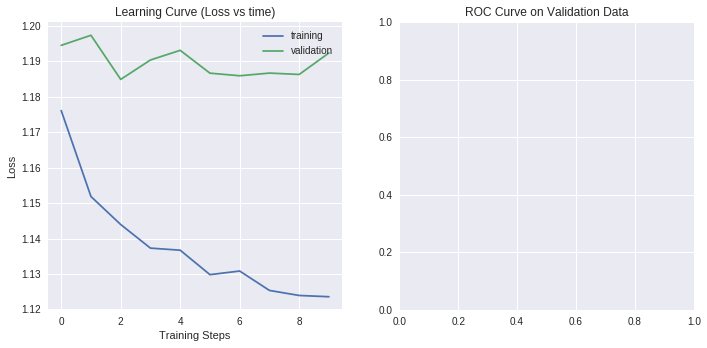

In [0]:
LEARNING_RATE = 0.15
L1_REGULARIZATION_STRENGTH = 0.0
L2_REGULARIZATION_STRENGTH = 0.1
DROPOUT_STRENGTH = 0.0
HIDDEN_UNITS = [25] #[7, 12, 13, 3]
BATCH_SIZE = 50
STEPS = 50000

DNN_classifier = define_DNN_classifier(
    learning_rate = LEARNING_RATE,
    hidden_units = HIDDEN_UNITS,
    l1_regularization_strength = L1_REGULARIZATION_STRENGTH,
    l2_regularization_strength = L2_REGULARIZATION_STRENGTH,
    dropout_regularization = DROPOUT_STRENGTH
)

DNN_classifier = train_model(
    DNN_classifier, training_examples[FEATURES],
    training_examples[LABEL], validation_examples[FEATURES],
    validation_examples[LABEL], batch_size=BATCH_SIZE, steps=STEPS)

Training model...
  Training loss, Validation loss after period 00 : 1.259, 1.328
  Training loss, Validation loss after period 01 : 1.231, 1.322
  Training loss, Validation loss after period 02 : 1.225, 1.360
  Training loss, Validation loss after period 03 : 1.218, 1.374
  Training loss, Validation loss after period 04 : 1.207, 1.337
  Training loss, Validation loss after period 05 : 1.206, 1.298
  Training loss, Validation loss after period 06 : 1.204, 1.334
  Training loss, Validation loss after period 07 : 1.199, 1.324
  Training loss, Validation loss after period 08 : 1.199, 1.316
  Training loss, Validation loss after period 09 : 1.198, 1.342
Final Loss (Log Loss) on the training data: 1.198
Final Loss (Log Loss) on the validation data: 1.342


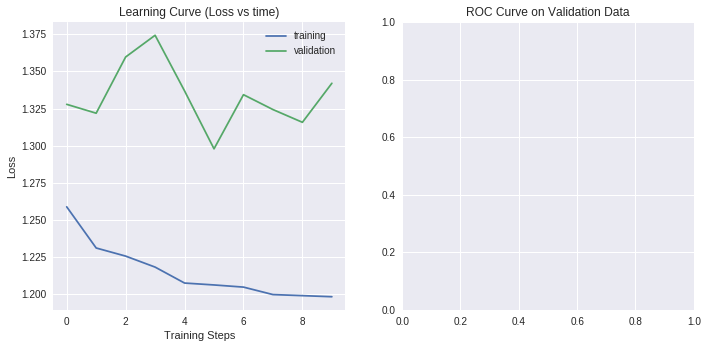

In [0]:
LEARNING_RATE = 0.5
L1_REGULARIZATION_STRENGTH = 0.3
L2_REGULARIZATION_STRENGTH = 0.5
DROPOUT_STRENGTH = 0.0
HIDDEN_UNITS = [14] #[7, 12, 13, 3]
BATCH_SIZE = 50
STEPS = 50000

DNN_classifier = define_DNN_classifier(
    learning_rate = LEARNING_RATE,
    hidden_units = HIDDEN_UNITS,
    l1_regularization_strength = L1_REGULARIZATION_STRENGTH,
    l2_regularization_strength = L2_REGULARIZATION_STRENGTH,
    dropout_regularization = DROPOUT_STRENGTH
)

DNN_classifier = train_model(
    DNN_classifier, training_examples[FEATURES],
    training_examples[LABEL], validation_examples[FEATURES],
    validation_examples[LABEL], batch_size=BATCH_SIZE, steps=STEPS)

Training model...
  Training loss, Validation loss after period 00 : 1.238, 1.336
  Training loss, Validation loss after period 01 : 1.206, 1.290
  Training loss, Validation loss after period 02 : 1.191, 1.289
  Training loss, Validation loss after period 03 : 1.184, 1.322
  Training loss, Validation loss after period 04 : 1.182, 1.333
  Training loss, Validation loss after period 05 : 1.177, 1.304
  Training loss, Validation loss after period 06 : 1.175, 1.310
  Training loss, Validation loss after period 07 : 1.173, 1.303
  Training loss, Validation loss after period 08 : 1.170, 1.300
  Training loss, Validation loss after period 09 : 1.171, 1.296
Final Loss (Log Loss) on the training data: 1.171
Final Loss (Log Loss) on the validation data: 1.296


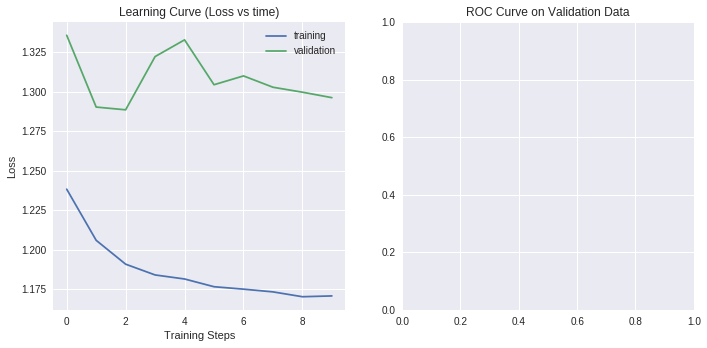

In [0]:
LEARNING_RATE = 0.1
L1_REGULARIZATION_STRENGTH = 0.0
L2_REGULARIZATION_STRENGTH = 0.1
DROPOUT_STRENGTH = 0.2
HIDDEN_UNITS = [57] #[7, 12, 13, 3]
BATCH_SIZE = 50
STEPS = 50000

DNN_classifier = define_DNN_classifier(
    learning_rate = LEARNING_RATE,
    hidden_units = HIDDEN_UNITS,
    l1_regularization_strength = L1_REGULARIZATION_STRENGTH,
    l2_regularization_strength = L2_REGULARIZATION_STRENGTH,
    dropout_regularization = DROPOUT_STRENGTH
)

DNN_classifier = train_model(
    DNN_classifier, training_examples[FEATURES],
    training_examples[LABEL], validation_examples[FEATURES],
    validation_examples[LABEL], batch_size=BATCH_SIZE, steps=STEPS)

Training model...
  Training loss, Validation loss after period 00 : 1.569, 1.571
  Training loss, Validation loss after period 01 : 1.507, 1.509
  Training loss, Validation loss after period 02 : 1.478, 1.478
  Training loss, Validation loss after period 03 : 1.460, 1.462
  Training loss, Validation loss after period 04 : 1.454, 1.458
  Training loss, Validation loss after period 05 : 1.446, 1.447
  Training loss, Validation loss after period 06 : 1.439, 1.441
  Training loss, Validation loss after period 07 : 1.437, 1.441
  Training loss, Validation loss after period 08 : 1.435, 1.438
  Training loss, Validation loss after period 09 : 1.433, 1.433
Final Loss (Log Loss) on the training data: 1.433
Final Loss (Log Loss) on the validation data: 1.433


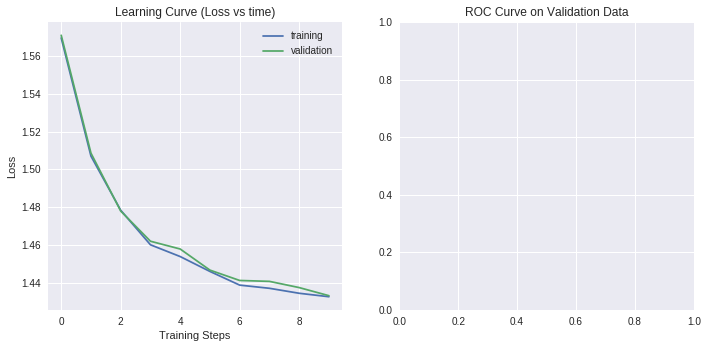

In [0]:
LEARNING_RATE = 0.1
L1_REGULARIZATION_STRENGTH = 0.0
L2_REGULARIZATION_STRENGTH = 0.1
DROPOUT_STRENGTH = 0.2
HIDDEN_UNITS = [14] #[7, 12, 13, 3]
BATCH_SIZE = 50
STEPS = 50000

DNN_classifier = define_DNN_classifier(
    learning_rate = LEARNING_RATE,
    hidden_units = HIDDEN_UNITS,
    l1_regularization_strength = L1_REGULARIZATION_STRENGTH,
    l2_regularization_strength = L2_REGULARIZATION_STRENGTH,
    dropout_regularization = DROPOUT_STRENGTH
)

DNN_classifier = train_model(
    DNN_classifier, training_examples[FEATURES],
    training_examples[LABEL], validation_examples[FEATURES],
    validation_examples[LABEL], batch_size=BATCH_SIZE, steps=STEPS)

Training model...
  Training loss, Validation loss after period 00 : 1.204, 1.207
  Training loss, Validation loss after period 01 : 1.169, 1.181
  Training loss, Validation loss after period 02 : 1.155, 1.170
  Training loss, Validation loss after period 03 : 1.151, 1.170
  Training loss, Validation loss after period 04 : 1.147, 1.173
  Training loss, Validation loss after period 05 : 1.147, 1.173
  Training loss, Validation loss after period 06 : 1.143, 1.173
  Training loss, Validation loss after period 07 : 1.143, 1.176
  Training loss, Validation loss after period 08 : 1.141, 1.172
  Training loss, Validation loss after period 09 : 1.139, 1.174
Final Loss (Log Loss) on the training data: 1.139
Final Loss (Log Loss) on the validation data: 1.174


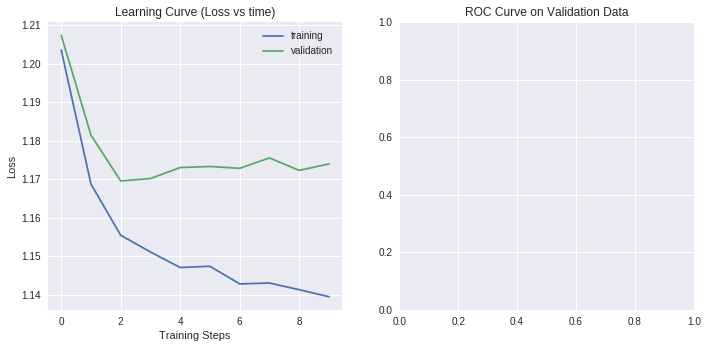

In [0]:
LEARNING_RATE = 0.15
L1_REGULARIZATION_STRENGTH = 0.0
L2_REGULARIZATION_STRENGTH = 0.1
DROPOUT_STRENGTH = 0.0
HIDDEN_UNITS = [14] #[7, 12, 13, 3]
BATCH_SIZE = 50
STEPS = 50000

DNN_classifier = define_DNN_classifier(
    learning_rate = LEARNING_RATE,
    hidden_units = HIDDEN_UNITS,
    l1_regularization_strength = L1_REGULARIZATION_STRENGTH,
    l2_regularization_strength = L2_REGULARIZATION_STRENGTH,
    dropout_regularization = DROPOUT_STRENGTH
)

DNN_classifier = train_model(
    DNN_classifier, training_examples[FEATURES],
    training_examples[LABEL], validation_examples[FEATURES],
    validation_examples[LABEL], batch_size=BATCH_SIZE, steps=STEPS)

Training model...
  Training loss, Validation loss after period 00 : 1.198, 1.201
  Training loss, Validation loss after period 01 : 1.168, 1.176
  Training loss, Validation loss after period 02 : 1.158, 1.163
  Training loss, Validation loss after period 03 : 1.154, 1.163
  Training loss, Validation loss after period 04 : 1.150, 1.163
  Training loss, Validation loss after period 05 : 1.150, 1.166
  Training loss, Validation loss after period 06 : 1.147, 1.163
  Training loss, Validation loss after period 07 : 1.146, 1.164
  Training loss, Validation loss after period 08 : 1.146, 1.165
  Training loss, Validation loss after period 09 : 1.145, 1.162
Final Loss (Log Loss) on the training data: 1.145
Final Loss (Log Loss) on the validation data: 1.162


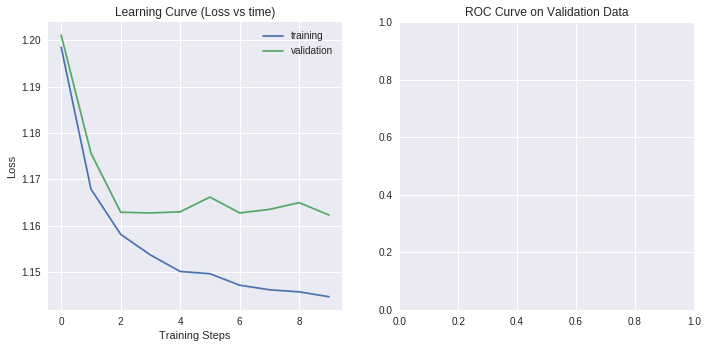

In [0]:
LEARNING_RATE = 0.13
L1_REGULARIZATION_STRENGTH = 0.0
L2_REGULARIZATION_STRENGTH = 0.1
DROPOUT_STRENGTH = 0.0
HIDDEN_UNITS = [14] #[7, 12, 13, 3]
BATCH_SIZE = 50
STEPS = 100000

DNN_classifier = define_DNN_classifier(
    learning_rate = LEARNING_RATE,
    hidden_units = HIDDEN_UNITS,
    l1_regularization_strength = L1_REGULARIZATION_STRENGTH,
    l2_regularization_strength = L2_REGULARIZATION_STRENGTH,
    dropout_regularization = DROPOUT_STRENGTH
)

DNN_classifier = train_model(
    DNN_classifier, training_examples[FEATURES],
    training_examples[LABEL], validation_examples[FEATURES],
    validation_examples[LABEL], batch_size=BATCH_SIZE, steps=STEPS)

Training model...
  Training loss, Validation loss after period 00 : 1.276, 1.274
  Training loss, Validation loss after period 01 : 1.215, 1.213
  Training loss, Validation loss after period 02 : 1.194, 1.191
  Training loss, Validation loss after period 03 : 1.181, 1.185
  Training loss, Validation loss after period 04 : 1.172, 1.175
  Training loss, Validation loss after period 05 : 1.167, 1.178
  Training loss, Validation loss after period 06 : 1.164, 1.179
  Training loss, Validation loss after period 07 : 1.159, 1.171
  Training loss, Validation loss after period 08 : 1.155, 1.169
  Training loss, Validation loss after period 09 : 1.152, 1.170
Final Loss (Log Loss) on the training data: 1.152
Final Loss (Log Loss) on the validation data: 1.170


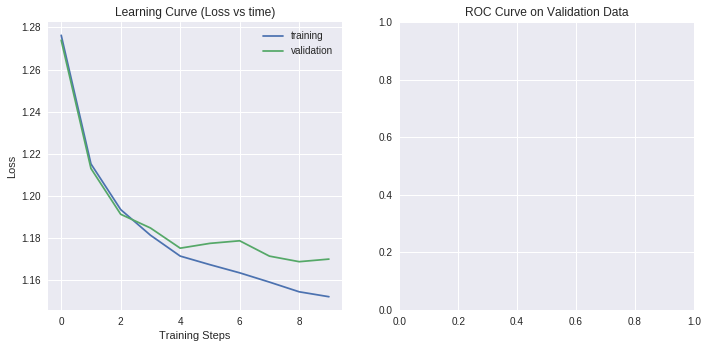

In [0]:
LEARNING_RATE = 0.1
L1_REGULARIZATION_STRENGTH = 0.0
L2_REGULARIZATION_STRENGTH = 0.1
DROPOUT_STRENGTH = 0.0
HIDDEN_UNITS = [17] #[7, 12, 13, 3]
BATCH_SIZE = 50
STEPS = 50000

DNN_classifier = define_DNN_classifier(
    learning_rate = LEARNING_RATE,
    hidden_units = HIDDEN_UNITS,
    l1_regularization_strength = L1_REGULARIZATION_STRENGTH,
    l2_regularization_strength = L2_REGULARIZATION_STRENGTH,
    dropout_regularization = DROPOUT_STRENGTH
)

DNN_classifier = train_model(
    DNN_classifier, training_examples[FEATURES],
    training_examples[LABEL], validation_examples[FEATURES],
    validation_examples[LABEL], batch_size=BATCH_SIZE, steps=STEPS)

Training model...
  Training loss, Validation loss after period 00 : 1.226, 1.234
  Training loss, Validation loss after period 01 : 1.182, 1.199
  Training loss, Validation loss after period 02 : 1.167, 1.183
  Training loss, Validation loss after period 03 : 1.156, 1.175
  Training loss, Validation loss after period 04 : 1.151, 1.172
  Training loss, Validation loss after period 05 : 1.150, 1.171
  Training loss, Validation loss after period 06 : 1.147, 1.174
  Training loss, Validation loss after period 07 : 1.145, 1.171
  Training loss, Validation loss after period 08 : 1.145, 1.176
  Training loss, Validation loss after period 09 : 1.142, 1.170
Final Loss (Log Loss) on the training data: 1.142
Final Loss (Log Loss) on the validation data: 1.170


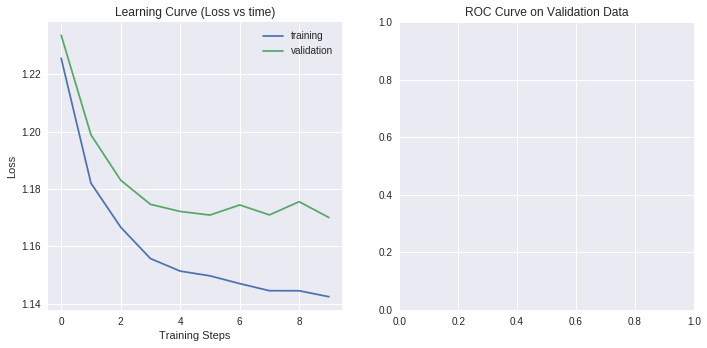

In [0]:
LEARNING_RATE = 0.1
L1_REGULARIZATION_STRENGTH = 0.0
L2_REGULARIZATION_STRENGTH = 0.1
DROPOUT_STRENGTH = 0.0
HIDDEN_UNITS = [16] #[7, 12, 13, 3]
BATCH_SIZE = 50
STEPS = 50000

DNN_classifier = define_DNN_classifier(
    learning_rate = LEARNING_RATE,
    hidden_units = HIDDEN_UNITS,
    l1_regularization_strength = L1_REGULARIZATION_STRENGTH,
    l2_regularization_strength = L2_REGULARIZATION_STRENGTH,
    dropout_regularization = DROPOUT_STRENGTH
)

DNN_classifier = train_model(
    DNN_classifier, training_examples[FEATURES],
    training_examples[LABEL], validation_examples[FEATURES],
    validation_examples[LABEL], batch_size=BATCH_SIZE, steps=STEPS)

Training model...
  Training loss, Validation loss after period 00 : 1.231, 1.237
  Training loss, Validation loss after period 01 : 1.182, 1.191
  Training loss, Validation loss after period 02 : 1.166, 1.177
  Training loss, Validation loss after period 03 : 1.155, 1.174
  Training loss, Validation loss after period 04 : 1.150, 1.175
  Training loss, Validation loss after period 05 : 1.145, 1.172
  Training loss, Validation loss after period 06 : 1.142, 1.173
  Training loss, Validation loss after period 07 : 1.138, 1.175
  Training loss, Validation loss after period 08 : 1.137, 1.178
  Training loss, Validation loss after period 09 : 1.136, 1.177
Final Loss (Log Loss) on the training data: 1.136
Final Loss (Log Loss) on the validation data: 1.177


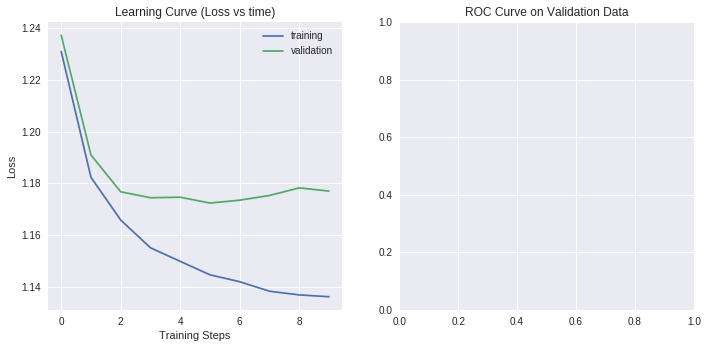

In [0]:
LEARNING_RATE = 0.1
L1_REGULARIZATION_STRENGTH = 0.0
L2_REGULARIZATION_STRENGTH = 0.1
DROPOUT_STRENGTH = 0.0
HIDDEN_UNITS = [15] #[7, 12, 13, 3]
BATCH_SIZE = 50
STEPS = 50000

DNN_classifier = define_DNN_classifier(
    learning_rate = LEARNING_RATE,
    hidden_units = HIDDEN_UNITS,
    l1_regularization_strength = L1_REGULARIZATION_STRENGTH,
    l2_regularization_strength = L2_REGULARIZATION_STRENGTH,
    dropout_regularization = DROPOUT_STRENGTH
)

DNN_classifier = train_model(
    DNN_classifier, training_examples[FEATURES],
    training_examples[LABEL], validation_examples[FEATURES],
    validation_examples[LABEL], batch_size=BATCH_SIZE, steps=STEPS)

Training model...
  Training loss, Validation loss after period 00 : 1.338, 1.328
  Training loss, Validation loss after period 01 : 1.261, 1.261
  Training loss, Validation loss after period 02 : 1.229, 1.227
  Training loss, Validation loss after period 03 : 1.210, 1.205
  Training loss, Validation loss after period 04 : 1.198, 1.196
  Training loss, Validation loss after period 05 : 1.192, 1.196
  Training loss, Validation loss after period 06 : 1.181, 1.182
  Training loss, Validation loss after period 07 : 1.178, 1.183
  Training loss, Validation loss after period 08 : 1.174, 1.183
  Training loss, Validation loss after period 09 : 1.171, 1.178
Final Loss (Log Loss) on the training data: 1.171
Final Loss (Log Loss) on the validation data: 1.178


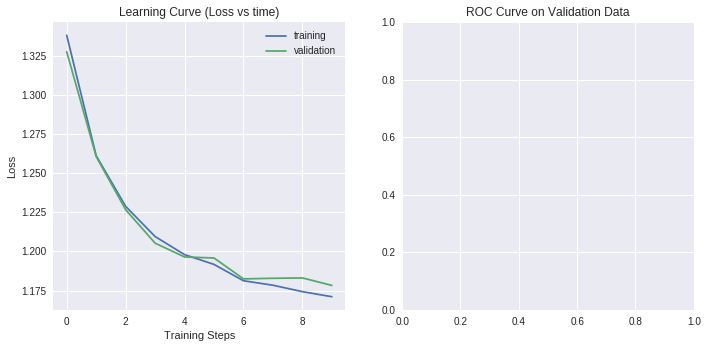

In [0]:
LEARNING_RATE = 0.1
L1_REGULARIZATION_STRENGTH = 0.0
L2_REGULARIZATION_STRENGTH = 0.1
DROPOUT_STRENGTH = 0.0
HIDDEN_UNITS = [14] 
BATCH_SIZE = 50
STEPS = 50000

DNN_classifier = define_DNN_classifier(
    learning_rate = LEARNING_RATE,
    hidden_units = HIDDEN_UNITS,
    l1_regularization_strength = L1_REGULARIZATION_STRENGTH,
    l2_regularization_strength = L2_REGULARIZATION_STRENGTH,
    dropout_regularization = DROPOUT_STRENGTH
)

DNN_classifier = train_model(
    DNN_classifier, training_examples[FEATURES],
    training_examples[LABEL], validation_examples[FEATURES],
    validation_examples[LABEL], batch_size=BATCH_SIZE, steps=STEPS)